# About the dataset
This dataset was downloaded from NEU Metal Surface Defects Databse which contains six kinds of typical surface defects of the hot-rolled steel strip are collected, i.e., rolled-in scale (RS), patches (Pa), crazing (Cr), pitted surface (PS), inclusion (In) and scratches (Sc). The database includes 1,800 grayscale images: 300 samples each of six different kinds of typical surface defects.

But for this analysis, the dataset divided into 3 directories. The training directory contains 276 images of each class from the 300 images. The rest 24 images of each class also divided into tests and valid datasets.

I don't know for sure about the dataset sharing as it's not my own data that's why I kept it private.

In [11]:
import numpy as np
import pandas as pd 
import os

In [12]:
train_dir = '/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data/train'
val_dir = '/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data/valid'
test_dir='/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data/test'
print("Path Direcorty: ",os.listdir("/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data"))
print("Train Direcorty: ",os.listdir("/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data/train"))
print("Test Direcorty: ",os.listdir("/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data/test"))
print("Validation Direcorty: ",os.listdir("/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data/valid"))

Path Direcorty:  ['Thumbs.db', 'valid', 'test', 'train']
Train Direcorty:  ['Inclusion', 'Rolled', 'Pitted', 'Scratches', 'Patches', 'Crazing']
Test Direcorty:  ['Inclusion', 'Rolled', 'Pitted', 'Scratches', 'Patches', 'Crazing']
Validation Direcorty:  ['Inclusion', 'Rolled', 'Pitted', 'Scratches', 'Patches', 'Crazing']


## Here, you can see the dataset distribution for 'Inclusion' surface defect. Rest of the dataset also follow the same distribution

In [13]:
print("Training Inclusion data:",len(os.listdir(train_dir+'/'+'Inclusion')))

print("Testing Inclusion data:",len(os.listdir(test_dir+'/'+'Inclusion')))

print("Validation Inclusion data:",len(os.listdir(val_dir+'/'+'Inclusion')))

Training Inclusion data: 276
Testing Inclusion data: 12
Validation Inclusion data: 12


In [14]:
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

## Pre-processing the data

In [15]:
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)


test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 10 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=10,
        class_mode='categorical')

# Flow validation images in batches of 10 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
        val_dir,
        target_size=(224, 224),
        batch_size=10,
        class_mode='categorical')

Found 1656 images belonging to 6 classes.
Found 72 images belonging to 6 classes.


## Stop training the model at 98% training accuracy

In [16]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') > 0.98 ):
            print("\nReached 98% accuracy so cancelling training!")
            self.model.stop_training = True 

In [17]:
num_classes = len(os.listdir(train_dir))
print("Number of classes:", num_classes)

Number of classes: 6


In [18]:
# Custom ResNet50 model
def custom_resnet50(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    # Residual blocks (three groups with 3, 4, and 6 convolutional layers)
    num_blocks_list = [3, 4, 6]
    filters_list = [64, 128, 256]
    for i in range(3):
        for j in range(num_blocks_list[i]):
            strides = 1 if i == 0 and j == 0 else 2
            x = residual_block(x, filters_list[i], strides)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return models.Model(inputs, outputs, name='custom_resnet50')

# Residual block
def residual_block(x, filters, strides):
    shortcut = x
    x = layers.Conv2D(filters, (1, 1), strides=strides)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filters * 4, (1, 1))(x)
    x = layers.BatchNormalization()(x)

    # Adjust shortcut connection dimensions if needed
    if strides != 1 or shortcut.shape[-1] != x.shape[-1]:
        shortcut = layers.Conv2D(filters * 4, (1, 1), strides=strides)(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Add()([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

# Create custom ResNet50 model
input_shape = (224, 224, 3)
model = custom_resnet50(input_shape, num_classes)

model.summary()

Model: "custom_resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_53 (Conv2D)              (None, 112, 112, 64) 9472        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_53 (BatchNo (None, 112, 112, 64) 256         conv2d_53[0][0]                  
__________________________________________________________________________________________________
activation_40 (Activation)      (None, 112, 112, 64) 0           batch_normalization_53[0][0]     
____________________________________________________________________________________

In [19]:
model.compile(loss=CategoricalCrossentropy(),
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])
print('Compiled!')

Compiled!


In [20]:
callbacks = myCallback()
history = model.fit(train_generator,
        batch_size = 32,
        epochs=10,
        validation_data=validation_generator,
        callbacks=[callbacks],
        verbose=1, shuffle=True)

Epoch 1/10
166/166 [==============================] - 26s 156ms/step - loss: 1.8234 - accuracy: 0.3188 - val_loss: 1.7979 - val_accuracy: 0.1667
Epoch 2/10
166/166 [==============================] - 21s 127ms/step - loss: 1.4943 - accuracy: 0.4203 - val_loss: 2.4065 - val_accuracy: 0.1667
Epoch 3/10
166/166 [==============================] - 20s 123ms/step - loss: 1.2793 - accuracy: 0.5169 - val_loss: 1.8178 - val_accuracy: 0.3611
Epoch 4/10
166/166 [==============================] - 21s 126ms/step - loss: 1.1394 - accuracy: 0.5525 - val_loss: 0.8924 - val_accuracy: 0.7361
Epoch 5/10
166/166 [==============================] - 21s 127ms/step - loss: 1.1348 - accuracy: 0.5700 - val_loss: 0.9640 - val_accuracy: 0.5972
Epoch 6/10
166/166 [==============================] - 20s 123ms/step - loss: 1.0557 - accuracy: 0.6178 - val_loss: 0.8599 - val_accuracy: 0.7778
Epoch 7/10
166/166 [==============================] - 21s 128ms/step - loss: 1.0371 - accuracy: 0.6141 - val_loss: 3.0139 - val_ac

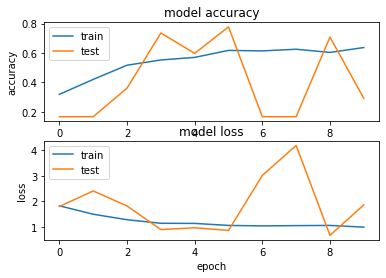

In [21]:
import matplotlib.pyplot as plt 
plt.figure(1)  
# summarize history for accuracy  
plt.subplot(211)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
   
 # summarize history for loss  
   
plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.show()


In [23]:
# Evaluate on the test set
test_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {test_accuracy * 100:.2f}%')

Found 72 images belonging to 6 classes.
3/3 [==============================] - 0s 59ms/step - loss: 1.7887 - accuracy: 0.3472
Test accuracy: 34.72%


In [25]:
from sklearn.metrics import classification_report, confusion_matrix

In [27]:
# Get the predicted probabilities and labels for the test set
y_pred_probs = model.predict(test_generator)
y_pred_labels = np.argmax(y_pred_probs, axis=1)
y_true_labels = test_generator.classes

# Calculate metrics using scikit-learn functions
accuracy = np.mean(y_pred_labels == y_true_labels)
report = classification_report(y_true_labels, y_pred_labels, target_names=test_generator.class_indices.keys())
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

# Print the metrics
print("Accuracy:", accuracy)
print("Classification Report:")
print(report)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.125
Classification Report:
              precision    recall  f1-score   support

     Crazing       0.09      0.25      0.13        12
   Inclusion       0.00      0.00      0.00        12
     Patches       0.08      0.08      0.08        12
      Pitted       0.00      0.00      0.00        12
      Rolled       0.14      0.17      0.15        12
   Scratches       0.33      0.25      0.29        12

    accuracy                           0.12        72
   macro avg       0.11      0.12      0.11        72
weighted avg       0.11      0.12      0.11        72

Confusion Matrix:
[[3 0 4 0 5 0]
 [6 0 1 0 1 4]
 [7 0 1 1 2 1]
 [8 0 0 0 3 1]
 [7 0 3 0 2 0]
 [4 0 3 1 1 3]]


# Test Result visualization

In [ ]:
# First, we are going to load the file names and their respective target labels into numpy array! 
from sklearn.datasets import load_files
import numpy as np

test_dir = '/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data/test'

def load_dataset(path):
    data = load_files(path)
    files = np.array(data['filenames'])
    targets = np.array(data['target'])
    target_labels = np.array(data['target_names'])
    return files,targets,target_labels
    
x_test, y_test,target_labels = load_dataset(test_dir)

In [ ]:
no_of_classes = len(np.unique(y_test))
no_of_classes

In [ ]:
from keras.utils import np_utils
y_test = np_utils.to_categorical(y_test,no_of_classes)


In [ ]:
# We just have the file names in the x set. Let's load the images and convert them into array.
from keras.preprocessing.image import array_to_img, img_to_array, load_img

def convert_image_to_array(files):
    images_as_array=[]
    for file in files:
        # Convert to Numpy Array
        images_as_array.append(img_to_array(load_img(file)))
    return images_as_array

x_test = np.array(convert_image_to_array(x_test))
print('Test set shape : ',x_test.shape)

In [ ]:
x_test = x_test.astype('float32')/255

In [ ]:
# Let's visualize test prediction.

y_pred = model.predict(x_test)

# plot a raandom sample of test images, their predicted labels, and ground truth
fig = plt.figure(figsize=(16, 9))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=16, replace=False)):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = np.argmax(y_pred[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(target_labels[pred_idx], target_labels[true_idx]),
                 color=("green" if pred_idx == true_idx else "red"))